In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import pyreadr
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from load_data import open_charac, add_general_charac
from torch.optim import SGD
from torch.utils.data import random_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from binaryclass_memory import *

# MAP BED to gene ID

In [29]:
norm = pd.read_csv('../data/merged_data/AE3.csv')
norm = norm.set_index('Unnamed: 0')
gene = norm.index

general_charac = pyreadr.read_r('../data/Characteristics_masterfiles/General_characteristics/EPFL_gene_master_matrix.RData')['gene_master_matrix']
general_charac = general_charac.set_index('gene_ID')
chrom_position = general_charac.loc[gene.intersection(general_charac.index),['chr','start','end']]

chrom_position.to_csv('../data/chrom_position.csv')

In [24]:
#Read .bed file 
lines = []
with open('../data/test.bed') as f:
    lines = f.readlines()
del lines[0]

#Only keep relevant info
lines = [line.split("\t")[:5] for line in lines]
histone_mark = [line[3].split("Name=",1)[1] for line in lines]
histone_mark = [line.split("%20",1)[0] for line in histone_mark]
lines = [line[:3] + [line[4]] for line in lines]

histone_bed = pd.DataFrame(lines, index = histone_mark, columns = ['chr', 'start', 'end', 'score'])
histone_bed = histone_bed.astype({"start": int, "end": int, "score":int})

In [48]:
def check_overlap(seq,chrom_position):
    name = None
    
    for i in range(chrom_position.shape[0]):
        if len(range(max(seq[1], chrom_position.iloc[i,1]), min(seq[2], chrom_position.iloc[i,2]+1))) != 0:
            name = chrom_position.iloc[i,:].index
    
    return name

for pos in chrom_position:
    histone_bed['gene_ID'] = histone_bed.apply(lambda x: check_overlap(x, chrom_position), axis=1)

KeyboardInterrupt: 

In [26]:
chrom_position

,chr,start,end
ENSMUSG00000051951,chr1,3276124,3741721
ENSMUSG00000089699,chr1,3536810,3583776
ENSMUSG00000102331,chr1,3717532,3729127
ENSMUSG00000102343,chr1,3975962,4056438
ENSMUSG00000025900,chr1,4069780,4479464
...,...,...,...
ENSMUSG00000065947,MT,9877,10173
ENSMUSG00000064363,MT,10167,11544
ENSMUSG00000064367,MT,11742,13565
ENSMUSG00000064368,MT,13552,14070


## Load data

In [7]:
general_charac = pyreadr.read_r('../data/Characteristics_masterfiles/General_characteristics/EPFL_gene_master_matrix.RData')['gene_master_matrix']

names = ['AE3', 'AE4', 'AE7', 'BIDDY_D0', 'BIDDY_D0_2', 'BIDDY_D6', 'BIDDY_D6_2', 'BIDDY_D15', 'BIDDY_D15_2',
        'LK_D2_exp1_library_d2_1', 'LK_D2_exp1_library_d2_2', 'LK_D2_exp1_library_d2_3', 'LK_LSK_D2_exp3_library_d2_1', 
        'LK_LSK_D2_exp3_library_d2_2', 'LK_LSK_D2_exp3_library_d2_3', 'LK_LSK_D2_exp3_library_d2_4', 
        'LK_LSK_D2_exp3_library_d2_5', 'LSK_D2_exp1_library_LSK_d2_1', 'LSK_D2_exp1_library_LSK_d2_2', 'LSK_D2_exp1_library_LSK_d2_3',
       'LSK_D2_exp2_library_d2A_1', 'LSK_D2_exp2_library_d2A_2', 'LSK_D2_exp2_library_d2A_3' , 'LSK_D2_exp2_library_d2A_4', 'LSK_D2_exp2_library_d2A_5', 
       'LSK_D2_exp2_library_d2B_1','LSK_D2_exp2_library_d2B_2', 'LSK_D2_exp2_library_d2B_3', 'LSK_D2_exp2_library_d2B_4', 'LSK_D2_exp2_library_d2B_5']
charac_matrix = []
norm_matrix = []
families_matrix = []
for name in names:
    #Open characteristics file
    charac_out_path = '../data/Characteristics_masterfiles/Dataset_specific_characteristics/' + name + '__characteristics_output.txt'
    p_value_path = '../data/Characteristics_masterfiles/Memory_genes/P_value_estimate_CV2_ofmeans_' + name + '.txt'
    charac_matrix.append(open_charac(charac_out_path, p_value_path, 200))
    
    #Open normalized data
    norm_path = '../data/merged_data/' + name + '.csv'
    fam_path = '../data/merged_data/y_' + name + '.csv'
    norm = pd.read_csv (norm_path)
    norm = norm.set_index('Unnamed: 0')
    families= np.squeeze(np.array(pd.read_csv(fam_path)))
    
    norm_matrix.append(norm)
    families_matrix.append(families)

In [3]:
#Add general characteristic
for i in range(0,len(charac_matrix)):
    charac_matrix[i] = add_general_charac(charac_matrix[i], general_charac)
    charac_matrix[i] = charac_matrix[i].drop(['CV2ofmeans_residuals','cell_cycle_dependence', 'skew', 'CV2ofmeans', 'exon_expr_median', 'exon_expr_mean'], axis=1)
    charac_matrix[i] = charac_matrix[i].dropna()

In [4]:
selector = SelectKBest(mutual_info_classif, k=18)
X_reduced = selector.fit_transform(X, y)
X_reduced.shape

cols = selector.get_support(indices=True)
selected_columns = X.iloc[:,cols].columns.tolist()
selected_columns

NameError: name 'X' is not defined

In [17]:
selector = SelectKBest(f_classif, k=18)
X_reduced = selector.fit_transform(X, y)
X_reduced.shape

cols = selector.get_support(indices=True)
selected_columns = X.iloc[:,cols].columns.tolist()
selected_columns

['skew_residuals',
 'mean_expression',
 'length',
 'GC',
 'Pou5f1',
 'Myc',
 'Nanog',
 'Sox2',
 'Dnmt3a',
 'Dnmt1',
 'H3K27me3',
 'H3K4me3',
 'H3K27ac',
 'H3K9me3',
 'H2Aub1',
 'Cbx5',
 'Ctnnb1',
 'Srebf1']

# Visualization data

AE3
100.0 % of the outliers are memory genes


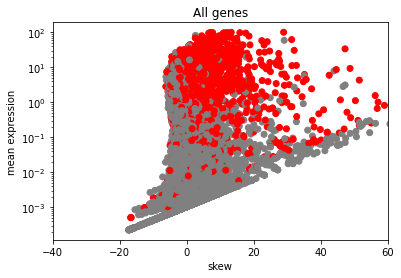

AE4
87.21804511278195 % of the outliers are memory genes


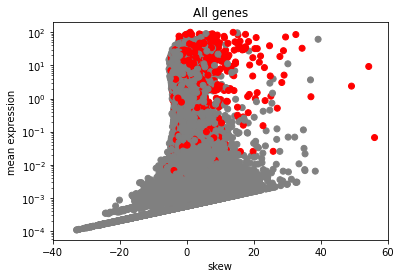

AE7
62.62626262626262 % of the outliers are memory genes


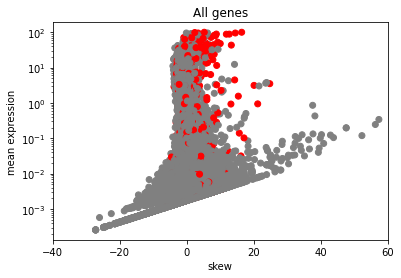

BIDDY_D0
92.3076923076923 % of the outliers are memory genes


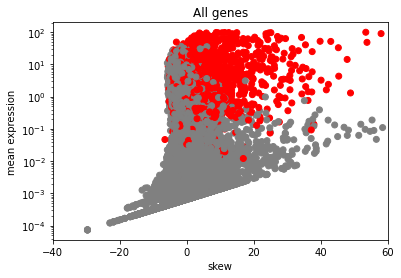

BIDDY_D0_2
95.29411764705883 % of the outliers are memory genes


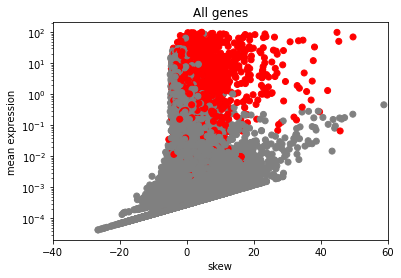

BIDDY_D6
97.29729729729729 % of the outliers are memory genes


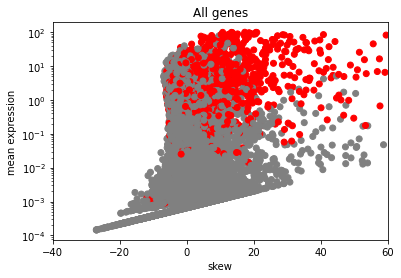

BIDDY_D6_2
72.09302325581395 % of the outliers are memory genes


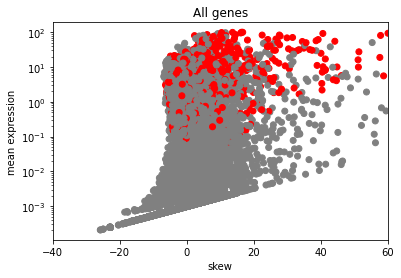

BIDDY_D15
94.20289855072464 % of the outliers are memory genes


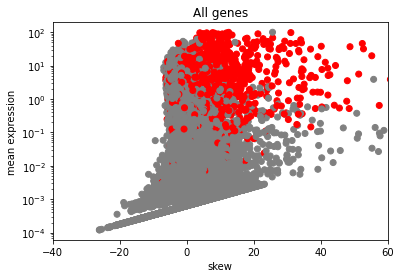

BIDDY_D15_2
92.3076923076923 % of the outliers are memory genes


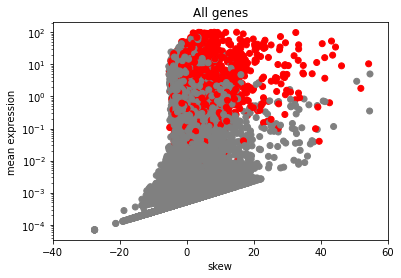

LK_D2_exp1_library_d2_1
91.66666666666667 % of the outliers are memory genes


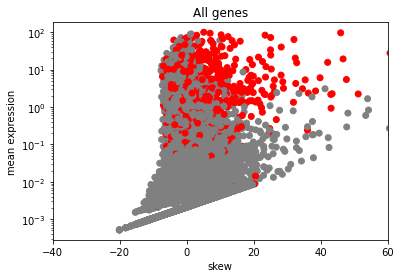

LK_D2_exp1_library_d2_2
100.0 % of the outliers are memory genes


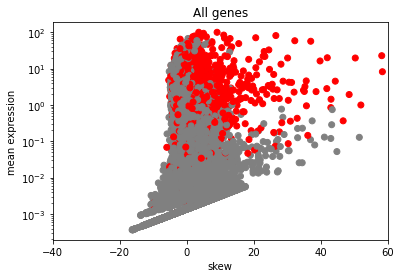

LK_D2_exp1_library_d2_3
83.33333333333333 % of the outliers are memory genes


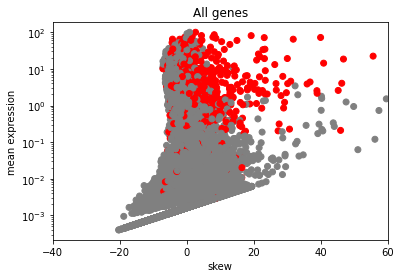

LK_LSK_D2_exp3_library_d2_1
76.92307692307692 % of the outliers are memory genes


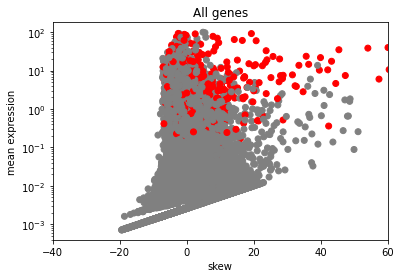

LK_LSK_D2_exp3_library_d2_2
100.0 % of the outliers are memory genes


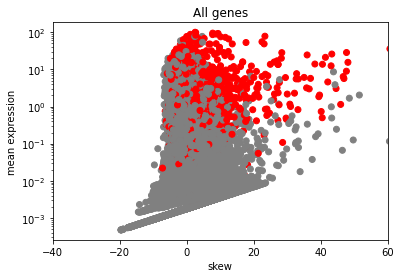

LK_LSK_D2_exp3_library_d2_3
100.0 % of the outliers are memory genes


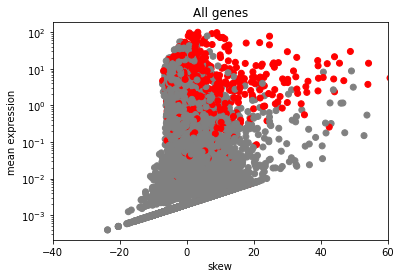

LK_LSK_D2_exp3_library_d2_4
100.0 % of the outliers are memory genes


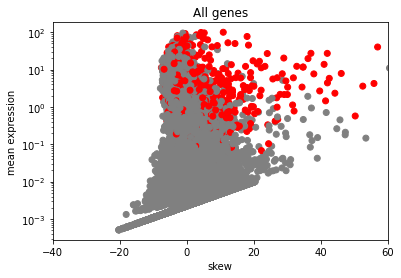

LK_LSK_D2_exp3_library_d2_5
91.66666666666667 % of the outliers are memory genes


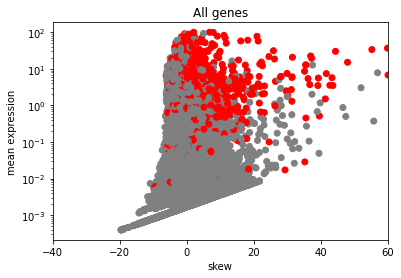

LSK_D2_exp1_library_LSK_d2_1
75.0 % of the outliers are memory genes


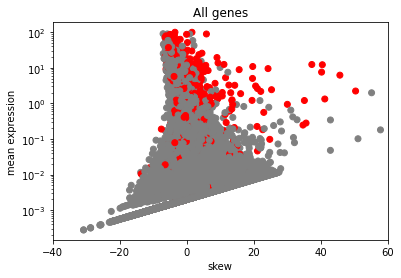

LSK_D2_exp1_library_LSK_d2_2
100.0 % of the outliers are memory genes


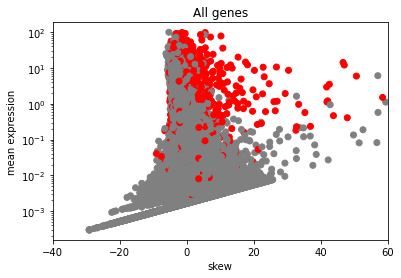

LSK_D2_exp1_library_LSK_d2_3
93.75 % of the outliers are memory genes


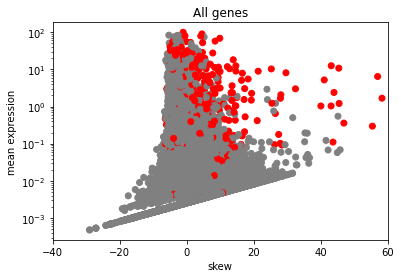

LSK_D2_exp2_library_d2A_1
100.0 % of the outliers are memory genes


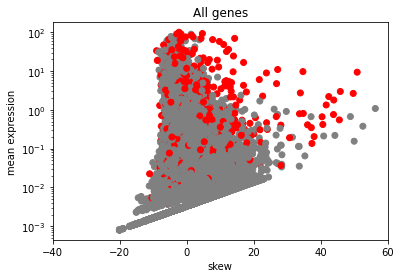

LSK_D2_exp2_library_d2A_2
91.66666666666667 % of the outliers are memory genes


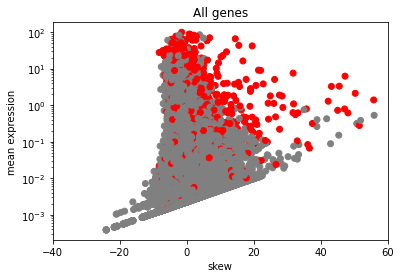

LSK_D2_exp2_library_d2A_3
92.3076923076923 % of the outliers are memory genes


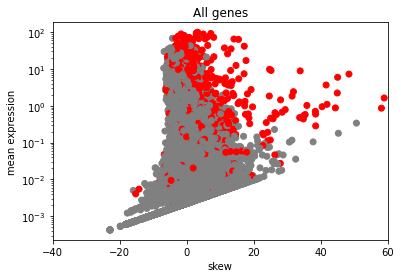

LSK_D2_exp2_library_d2A_4
100.0 % of the outliers are memory genes


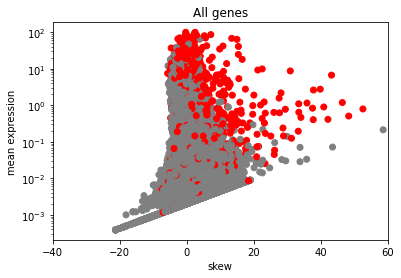

LSK_D2_exp2_library_d2A_5
100.0 % of the outliers are memory genes


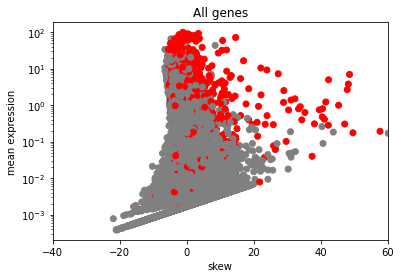

LSK_D2_exp2_library_d2B_1
100.0 % of the outliers are memory genes


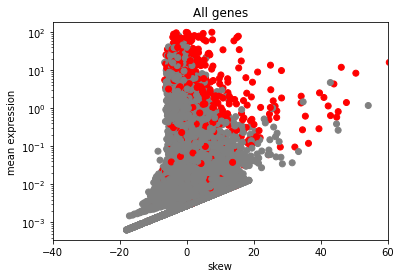

LSK_D2_exp2_library_d2B_2
71.42857142857143 % of the outliers are memory genes


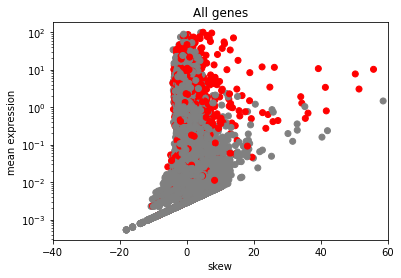

LSK_D2_exp2_library_d2B_3
90.0 % of the outliers are memory genes


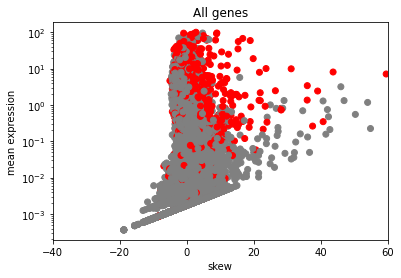

LSK_D2_exp2_library_d2B_4
100.0 % of the outliers are memory genes


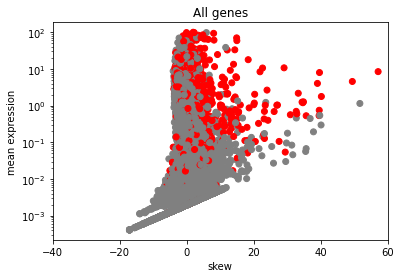

LSK_D2_exp2_library_d2B_5
90.9090909090909 % of the outliers are memory genes


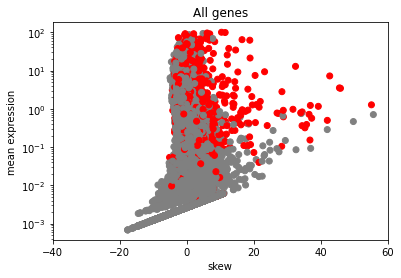

In [8]:
for i,charac in enumerate(charac_matrix):
    print(names[i])
    visualize_charac(charac)

In [17]:
np.max(charac_matrix[0]['Pou5f1'][charac_matrix[0]['Pou5f1'] != 0])

2.486

# Fuse charac data 

In [6]:
#Remove AE7, also keep BIDDYD15_2 for validation
val = [0,8]
data_to_fuse = [1,3,4,5,6,7] 

outliers = []
for data in charac_matrix:
    #Normalize skew_residuals, same for mean_expression after removing outliers
    charac_matrix[i], outlier_temp = remove_extreme_values(charac_matrix[i], k=200)
    outliers.append(outlier_temp)
    charac_matrix[i]['skew_residuals'], charac_matrix[i]['mean_expression'] = normalize(charac_matrix[i]['skew_residuals']), normalize(charac_matrix[i]['mean_expression'])

val_charac =  []
for i in val:
    val_charac.append(charac_matrix[i])

fused_charac = []
names_fused = []
for i in data_to_fuse:
    fused_charac.append(charac_matrix[i])
    names_fused.append(names[i])
    
fused = pd.concat(fused_charac)

# Neural Network (NN)

In [32]:
def load_data (fused:pd.DataFrame, params):
    X = np.array(fused.drop(columns=['memory_gene']))
    y = np.expand_dims((fused['memory_gene']*1), axis=1)
    dataset = Dataset(np.array(X), y)

    N = len(y)
    train, test = random_split(dataset, [math.floor(N*0.8), math.ceil(N*0.2)], generator=torch.Generator().manual_seed(42))
    train_dl = DataLoader(train, batch_size= 32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    
    return train_dl, test_dl

In [17]:
def load_charac():
    #Load data
    general_charac = pyreadr.read_r('../data/Characteristics_masterfiles/General_characteristics/EPFL_gene_master_matrix.RData')['gene_master_matrix']

    names = ['AE3', 'AE4', 'AE7', 'BIDDY_D0', 'BIDDY_D0_2', 'BIDDY_D6', 'BIDDY_D6_2', 'BIDDY_D15', 'BIDDY_D15_2']

    charac_matrix = []
    for name in names:
        #Open characteristics file
        charac_out_path = '../data/Characteristics_masterfiles/Dataset_specific_characteristics/' + name + '__characteristics_output.txt'
        p_value_path = '../data/Characteristics_masterfiles/Memory_genes/P_value_estimate_CV2_ofmeans_' + name + '.txt'
        charac_matrix.append(open_charac(charac_out_path, p_value_path, 200))

    #Add general characteristic
    for i in range(0,len(charac_matrix)):
        charac_matrix[i] = add_general_charac(charac_matrix[i], general_charac)
        charac_matrix[i] = charac_matrix[i].drop(['CV2ofmeans_residuals','cell_cycle_dependence', 'skew', 'CV2ofmeans', 'exon_expr_median', 'exon_expr_mean'], axis=1)
        charac_matrix[i] = charac_matrix[i].dropna()

    #Remove AE7, also keep BIDDYD15_2 for validation
    val = [8]
    data_to_fuse = [0,1,3,4,5,6,7]

    for data in charac_matrix:
        #Normalize skew_residuals, same for mean_expression after removing outliers
        charac_matrix[i], outliers = remove_extreme_values(charac_matrix[i], k=200)
        charac_matrix[i]['skew_residuals'], charac_matrix[i]['mean_expression'] = normalize(charac_matrix[i]['skew_residuals']), normalize(charac_matrix[i]['mean_expression'])

    val_charac =  []
    for i in val:
        val_charac.append(charac_matrix[i])
    fused_charac = []
    name_fused = []
    for i in data_to_fuse:
        fused_charac.append(charac_matrix[i])
        name_fused.append(names[i])

    fused = pd.concat(fused_charac)
    
    return fused

In [18]:
#NN equivalent to logistic regression
class NN(nn.Module):
    def __init__(self, n_inputs, params=None):
        super(NN, self).__init__()
        self.layer = nn.Linear(n_inputs, 1)
        nn.init.xavier_uniform_(self.layer.weight)
 
    def forward(self, X):
        X = self.layer(X)
        return X

In [19]:
def train_model(train_dl, model, criterion, optimizer):
    for epoch in range(100):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            #Convert double to float
            inputs, targets = inputs.to(torch.float32),  targets.to(torch.float32)

            optimizer.zero_grad()
            yhat = model(inputs)
            loss = criterion(yhat, targets)
            loss.backward()
            optimizer.step()

def evaluate_model(test_dl, model):
    with torch.no_grad():
        acc = []
        for i, (inputs, targets) in enumerate(test_dl):
            #Convert double to float
            inputs, targets = inputs.to(torch.float32),  targets.to(torch.float32)

            # evaluate the model on the test set
            yhat = torch.sigmoid(model(inputs))
            yhat[yhat >= 0.5] = 1; yhat[yhat < 0.5] = 0

            acc.append(balanced_accuracy_score(y_true = targets, y_pred = yhat))

    return np.mean(acc)

def predict(inputs, model):
    inputs =torch.Tensor([inputs])
    yhat = torch.sigmoid(model(inputs))
    yhat[yhat >= 0.5] = 1; yhat[yhat < 0.5] = 0
    
    return yhat.detach().numpy()

In [54]:
FS = ['skew_residuals', 'mean_expression', 'length', 'GC', 'Myc', 'Nanog', 'Sox2', 'H3K4me3', 'H3K27ac', 'Ctnnb1', 'Srebf1','memory_gene']

train_dl, test_dl = load_data(fused[FS])

model = NN(len(FS)-1)

#Optmization criterion and optimizer
num_positives= np.sum(dataset.labels); num_negatives = len(dataset.labels) - num_positives
pos_weight  = torch.as_tensor(num_negatives / num_positives, dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

train_model(train_dl, model)
evaluate_model(test_dl,model)

NameError: name 'fused' is not defined

In [55]:
X = np.array(fused[FS].drop(columns=['memory_gene']))
y = np.expand_dims((fused['memory_gene']*1), axis=1)
dataset = Dataset(np.array(X), y)

yhat = predict(dataset.charac, model)

acc = balanced_accuracy_score(y_true = y, y_pred = np.squeeze(yhat))
recovery = np.sum(y*yhat)/np.sum(y)   
FP = np.sum(np.logical_and(yhat == 1, y*yhat == 0))
    
[acc, recovery, FP]

NameError: name 'fused' is not defined

In [20]:
def obj(trial, fused):
    #Set hyperparamters to tune
    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 100),
              'weight_decay' : trial.suggest_loguniform('weight_decay', 1e-5, 1),
              'n': trial.suggest_int("n", 4, 50),
              'batch_size': trial.suggest_int("batch_size", 5, 8), #2^i
              'nb_features' : trial.suggest_int("nb_features", 2, 18)
              }
    #Load data
    X = fused.drop(columns=['memory_gene'])
    y = fused['memory_gene']*1
    
    #Get the N top features according to mutual information
    selector = SelectKBest(mutual_info_classif, k=params['nb_features'])
    X_redu = selector.fit_transform(X, y)
    cols = selector.get_support(indices=True)
    FS = X.iloc[:,cols].columns.tolist(); FS.append('memory_gene')

    train_dl, test_dl = load_data(fused[FS],params)

    model = NN(len(FS)-1, params)

    #Optmization criterion and optimizer
    num_positives= np.sum(y); num_negatives = len(y) - num_positives
    pos_weight  = torch.as_tensor(num_negatives / num_positives, dtype=torch.float)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9, weight_decay=params['weight_decay'])

    #Train and evaluate the NN
    train_model(train_dl, model, criterion, optimizer)
    acc = evaluate_model(test_dl,model)
    
    return acc

class Objective(object):
    def __init__(self, fused):
        self.fused = fused

    def __call__(self, trial):
        
        acc = obj(trial, self.fused)
        
        return acc

In [30]:
fused = load_charac()
objective = Objective(fused)

In [33]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2022-05-24 13:48:59,574] A new study created in memory with name: no-name-5af2be93-2ebe-4053-a581-648a54c027ad


KeyboardInterrupt: 